In [1]:
import matplotlib.pyplot as plt
from math import isclose
from sklearn.decomposition import PCA
from sklearn import svm
import os
import networkx as nx
import numpy as np
import pandas as pd
from stellargraph import StellarGraph, datasets
from stellargraph.data import EdgeSplitter
from collections import Counter
import multiprocessing
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
#import glob3


%matplotlib inline

In [2]:
#----------------Load the dataset-----------------------------------

In [3]:
#Setup of Dataset objects and procedures

#Load The Dataset from files
graph_train1 = ("/home/ubuntu/ssl/COVID_Data/Updated Paper Graph_node2vec/Train_Graphs/Graph_train-complete/graph_train_complete_1.gml")

#examples_train in the example .csv file
examples_train_df = pd.read_csv("/home/ubuntu/ssl/COVID_Data/Updated Paper Graph_node2vec/Train_Graphs/Graph_train_edges/graph_train_edges_sampled_1.csv") #named examples_train in the example (edited)

examples_train_df = examples_train_df.replace(np.nan, 'nan', regex=True)
labels_train = list(examples_train_df['training_labels'])
examples_train = [[i, j] for i, j in zip(list(examples_train_df['training_node1']), list(examples_train_df['training_node2']))]

#----------------------------------------------------------------------------------------


#examples_model_selection in the example .csv file
examples_model_selection_df = pd.read_csv("/home/ubuntu/ssl/COVID_Data/Updated Paper Graph_node2vec/Validation_Graphs/Graph_validation_edges/graph_validation_edges_sampled_1.csv") #header=None, na_values="NaN") #named examples_model_selection in the example (edited)

examples_model_selection_df = examples_model_selection_df.replace(np.nan, 'nan', regex=True)
labels_model_selection = list(examples_model_selection_df['validation_labels'])
examples_model_selection = [[i, j] for i, j in zip(list(examples_model_selection_df['validation_node1']), list(examples_model_selection_df['validation_node2']))]
#----------------------------------------------------------------------------------------



#graph_test in the example .gml file
graph_test = ("/home/ubuntu/ssl/COVID_Data/Updated Paper Graph_node2vec/Test_Graphs/Graph_test/graph_test_1.gml.gz") # named graph_test in the example
#----------------------------------------------------------------------------------------


#examples_test in the example .csv file
examples_test_df = pd.read_csv("/home/ubuntu/ssl/COVID_Data/Updated Paper Graph_node2vec/Test_Graphs/Graph_test_edges/graph_test_edges_1.csv") #named examples_test in the example (edited)

examples_test_df = examples_test_df.replace(np.nan, 'nan', regex=True)
labels_test = list(examples_test_df['labels'])
examples_test = [[i, j] for i, j in zip(list(examples_test_df['node1']), list(examples_test_df['node2']))]
#----------------------------------------------------------------------------------------

#Assign graph_test data to variable g 
gphtr = nx.read_gml(graph_test)

#Assign grpah_test networkx data utlilzing Stellargraph 
ntxStgrphTST = StellarGraph.from_networkx(gphtr)


#Assign graph_train data to variable g 
g = nx.read_gml(graph_train1 )

#Assign networkx data utlilzing Stellargraph 
ntxStgrph = StellarGraph.from_networkx(g)



In [8]:
pd.DataFrame(
    [
        (
            "Training Set",
            len(examples_train),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(examples_model_selection),
            "Train Graph",
            "Test Graph",
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(examples_test),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")

,Number of Examples,Hidden from,Picked from,Use
Split,,,,
Training Set,145209,Train Graph,Test Graph,Train the Link Classifier
Model Selection,48403,Train Graph,Test Graph,Select the best Link Classifier model
Test set,215124,Test Graph,Full Graph,Evaluate the best Link Classifier


In [9]:
# ------------------------------  Node2Vec -----------------------------

In [11]:
from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec

dimensions = 128
num_walks = 16
walk_length = 100
window_size = 16
workers = multiprocessing.cpu_count()

def node2vec_embedding(graph, name, p, q):
    rw = BiasedRandomWalk(graph)
    walks = rw.run(graph.nodes(), n=num_walks, length=walk_length, p=p, q=q, weighted=True)
    print(f"Number of weighted random walks for '{name}': {len(walks)}")

    model = Word2Vec(
        walks,
        size=dimensions,
        window=window_size,
        min_count=0,
        sg=1,
        workers=workers,
        #iter=num_iter,
    )

    def get_embedding(u):
        return model.wv[u]

    return get_embedding

In [27]:
#Below are a set of helper functions that let us repeat these steps
# for each of the binary operators.

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

#--------------------------------------------------------
#------Support Vector Classifier : Need to be implmented 
#from sklearn.svm import SVC

#-------------------------------------------------------
##---- Naive Bayes : Need to be implmented 
#from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# 1. link embeddings
def link_examples_to_features(link_examples, transform_node, binary_operator):
    return [
        binary_operator(transform_node(src), transform_node(dst))
        for src, dst in link_examples
    ]


# 2. training classifier
def train_link_prediction_model(
    link_examples, link_labels, get_embedding, binary_operator
):
    clf = link_prediction_classifier()
    link_features = link_examples_to_features(
        link_examples, get_embedding, binary_operator
    )
    clf.fit(link_features, link_labels)
    return clf


def link_prediction_classifier(max_iter=2000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


# 3. and 4. evaluate classifier
def evaluate_link_prediction_model(
    clf, link_examples_test, link_labels_test, get_embedding, binary_operator, filenametosave
):
    link_features_test = link_examples_to_features(
        link_examples_test, get_embedding, binary_operator
    )
    score_auc, score_acc = evaluate_roc_auc(clf, link_features_test, link_labels_test, filenametosave)

    return score_auc, score_acc

def computeAccuracy(list_pred_res, list_real_res):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i_ in range(len(list_pred_res)):
        # find out if the nodes are connected in the g_test
        is_connected = list_real_res[i_]
        prediction = list_pred_res[i_]
       # if is_connected and prediction == 1:
        if is_connected and prediction >= 0.5:
            tp += 1
        #elif is_connected and prediction == 0:
        elif is_connected and prediction < 0.5: 
            fn += 1
        #elif not is_connected and prediction == 0:
        elif not is_connected and prediction < 0.5:    
            tn += 1
        #elif not is_connected and prediction == 1:
        elif not is_connected and prediction >= 0.5:    
            fp += 1
        else:
            print('Error!')
        i_ += 1
    return (tp + tn)/float(tp+tn+fp+fn)

def evaluate_roc_auc(clf, link_features, link_labels, filename):
    predicted = clf.predict_proba(link_features)
    #predicted = clf.predict(link_features)
 
     # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    #positive_column = 1
    
    if len(filename) > 0: # save only when its not empty
        #Open and Write results to file.
        fo = open("/home/ubuntu/ssl/COVID_Data/"+filename+".txt","w")
        for i in predicted[:, positive_column]:
            fo.write(str(i)+'\n')

    #This was chancged 
    #score_acc = computeAccuracy(predicted, link_labels)
    score_acc = computeAccuracy(predicted[:, positive_column], link_labels)
    
    #score_acc = computeAccuracy(predicted4acc, link_labels)
    return roc_auc_score(link_labels, predicted[:, positive_column]), score_acc

def operator_hadamard(u, v):
    return u * v


def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def operator_avg(u, v):
    return (u + v) / 2.0

binary_operators = [operator_hadamard, operator_l1, operator_l2, operator_avg]

def test_run_link_prediction(binary_operator, embedding_train_):
    clf = train_link_prediction_model(
        examples_train, labels_train, embedding_train_, binary_operator
    )
    score_auc, score_acc = evaluate_link_prediction_model(
        clf,
        examples_model_selection,
        labels_model_selection,
        embedding_train_,
        binary_operator,
        '' # means don't save
    )

    return score_auc, score_acc

In [10]:
# Ulya Bayram
# ulyabayram@gmail.com
# Here Perform grid-search CV to find best p and q parameters optimizing the training data correctly predicting the validation set
# Define the other parameters globally
import itertools

def findBestRandWalkParams(ntxStgrph):

    p_q_set = [0.25, 0.5, 1, 2, 4]

    param_combo = list(itertools.product(p_q_set, p_q_set))

    score_best, parm_best = 0,()
    for param in param_combo:
        p_, q_ = param

        curr_embedding = node2vec_embedding(ntxStgrph, "Train Graph", p_, q_)

        results = [test_run_link_prediction(binary_operator, curr_embedding) for op in binary_operators] #score_auc, score_acc = 
        currbest_result = max(results, key=lambda result: result["score_auc"])
        if currbest_result["score_auc"] > score_best:
            score_best = currbest_result["score_auc"]
            param_best = param
            binary_op_best = currbest_result

    return param_best[0], param_best[1], binary_op_best

p, q, best_result = findBestRandWalkParams(ntxStgrph)

print('Best p parameter ' + str(p))
print('Best q parameter ' + str(q))
print('Best binary operator ' + str(best_result['binary_operator'].__name__))

In [12]:
embedding_train = node2vec_embedding(ntxStgrph, "Train Graph", p, q)

Number of random walks for 'Train Graph': 2655260


In [28]:
def run_link_prediction(binary_operator, filename2save):
    clf = train_link_prediction_model(
        examples_train, labels_train, embedding_train, binary_operator
    )
    score_auc, score_acc = evaluate_link_prediction_model(
        clf,
        examples_model_selection,
        labels_model_selection,
        embedding_train,
        binary_operator,
        filename2save
    )

    return {
        "classifier": clf,
        "binary_operator": binary_operator,
        "score_auc": score_auc,
        "score_acc": score_acc
    }

In [29]:
#results = [run_link_prediction(op, 'predicted_validation_result_split1_' + str(op)) for op in binary_operators]
#best_result = max(results, key=lambda result: result["score_auc"])

#print(f"Best AUC result from '{best_result['binary_operator'].__name__}'")

#pd.DataFrame(
#    [(result["binary_operator"].__name__, result["score_auc"]) for result in results],
#    columns=("name", "ROC AUC score"),
#).set_index("name")

Best result from 'operator_avg'


,ROC AUC score
name,
operator_hadamard,"(0.6761546316883934, 0.629279176910522)"
operator_l1,"(0.7049721604547579, 0.6497324545999215)"
operator_l2,"(0.7048759852824567, 0.6484928620126852)"
operator_avg,"(0.8279269756958493, 0.7483007251616636)"


In [ ]:
#------------------ Evaluate the best model using the test set-----------------

In [30]:
embedding_test = node2vec_embedding(ntxStgrphTST, "Test Graph", p, q)

Number of random walks for 'Test Graph': 2655260


In [31]:
test_score_auc, test_score_acc = evaluate_link_prediction_model(
    best_result["classifier"],
    examples_test,
    labels_test,
    embedding_test,
    best_result["binary_operator"],
    'predicted_test_result_split1_' + str(best_result["binary_operator"])
)
print(
    f"ROC AUC score on test set using '{best_result['binary_operator'].__name__}': {test_score_auc}"
)
print(
    f"Accuracy score on test set using '{best_result['binary_operator'].__name__}': {test_score_acc}"
)

ROC AUC score on test set using 'operator_avg': 0.6210342921475266
Accuracy score on test set using 'operator_avg': 0.586466410070471


ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not r

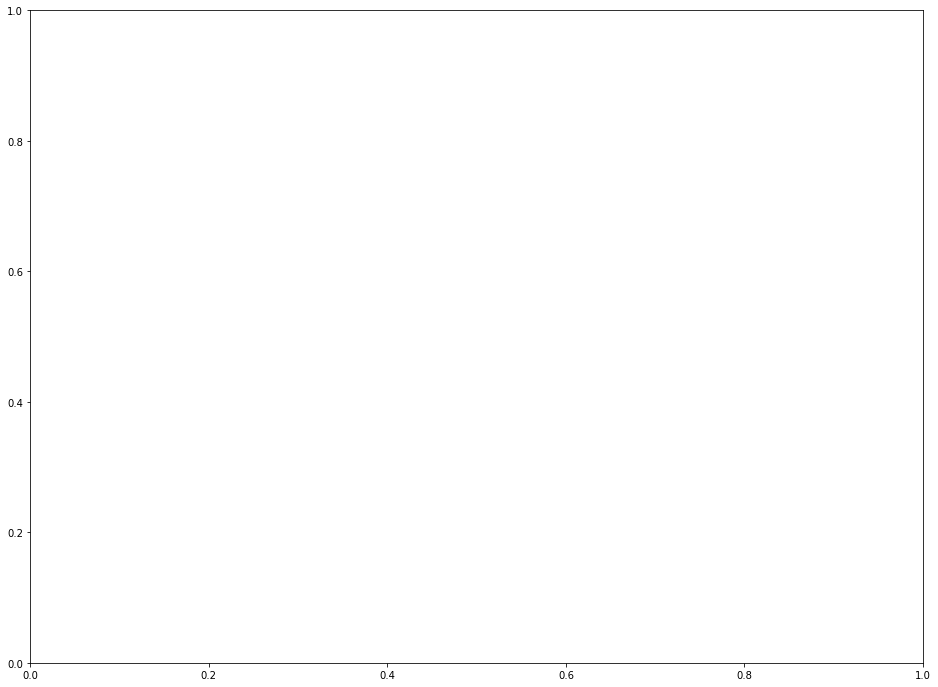

In [32]:
# Calculate edge features for test data
link_features = link_examples_to_features(
    examples_test, embedding_test, best_result["binary_operator"]
)

# Learn a projection from 128 dimensions to 2
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(link_features)

# plot the 2-dimensional points
plt.figure(figsize=(16, 12))
plt.scatter(
    X_transformed[:, 0],
    X_transformed[:, 1],
    c=np.where(labels_test == 1, "b", "r"),
    alpha=0.5,
)